# Map particles in tomograms

* Starting from a star file, extracts and calculates parameters (positions and angular orientations) needed to visualize (map) particles in ChimeraX and Paraview
* Generates tomos where particle averages are mapped according to the exact position and angular orientation of particles   

## Initialization

In [1]:
import sys
import os
import pickle
from copy import copy, deepcopy
import re
import itertools
import pathlib
import logging

import numpy as np
import scipy as sp
import pandas as pd 
import skimage
import matplotlib.pyplot as plt
import seaborn as sb

import pyto
from pyto.io.pandas_io import PandasIO
from pyto.geometry.rigid_3d import Rigid3D
import pyto.particles.relion_tools as relion_tools
from pyto.particles.relion_tools import get_array_data
from pyto.spatial.multi_particle_sets import MultiParticleSets
from pyto.projects.presynaptic import Presynaptic, tomo_generator
from pyto.spatial.visualization import Visualization

%autosave 0
sys.version

Autosave disabled


'3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:53:32) [GCC 12.3.0]'

In [2]:
# Settings

# force showing all rows in a table (default 60 rows)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# prevent matplotlib DEBUG logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.INFO)

# set hostname
hostname = os.uname()[1]
print(f"Host: {hostname}")

Host: rauna


### Figures 

In [3]:
# Useful functions for figures

# set plot parameters
def set_plot(plot_type):
    
    # for making figures 
    if plot_type == 'figure_save':
        # for some reason need to repeat
        %matplotlib qt
        plt.rcParams['font.size'] = 16  
        %matplotlib qt
        plt.rcParams['font.size'] = 16
    
    # figure-like inline
    if plot_type == 'figure_inline':
        %matplotlib inline
        plt.rcParams['font.size'] = 16
    
    # standard inline
    if plot_type == 'inline':
        %matplotlib inline
        plt.rcParams["figure.figsize"] = [4.5, 3]  # workaround changed size 2.2023


In [4]:
# choose figure type, uncomment one
#plot_type = 'figure_save' 
plot_type = 'figure_inline'
#plot_type = 'inline'

set_plot(plot_type)

# directory to save plots (only if plot_type = 'figure_save')
plot_root = os.path.join(
    pathlib.Path.home(), 'some_directory')

#sb.set_theme()
sb.set_context('notebook')
sb.set_style('white')
sb.set_style('ticks')

## Main

### Parameters and definitions

In [5]:
# local function definition

def plot_relion_angles(particles):
    """Plots angles from relion particle star file.

    Argument:
      - particles: (pandas.DataFrame) table obtained from star file
    """
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    ax = sb.scatterplot(
        data=particles, y='rlnAnglePsi', x='rlnAngleRot', 
        legend=False, ax=axs[0])
    ax = sb.scatterplot(
        data=particles, y='rlnAnglePsi', x='rlnAngleTilt', 
        legend=False, ax=axs[1])
    axs[0].set_xlim(0, 360)
    axs[1].set_xlim(0, 180)
    axs[0].set_ylim(0, 360)
    axs[1].set_ylim(0, 360); 

### Map particles from a Relion 4 star file

Uses Munc13 class average 

In [6]:
# Parameters

# star particle data table name 
table_name = 'data_particles'

# star column from which tomo id is determined
tomo_id_star_column = 'rlnTomoName'

# star column from which particle id is determined 
particle_id_star_column = 'rlnTomoParticleId'

# specify tomo id and define how it is extracted from tomo_id_star_column 
# Generic method: tomo ids are the column values
tomo_id = 'tomo_1-2-003'
tomo_id_mode = None
tomo_id_func = None
tomo_id_kwargs = {}
# Alternative 1: tomo id is tomo base file name without extension
#tomo_id = 'm13_ctrl_327'
#tomo_id_mode = None
#tomo_id_func = (lambda x: os.path.splitext(os.path.basename(x))[0])
#tomo_id_kwargs = {}
# Alternative 2: Used for the munc13-snap25 presynaptic project
#tomo_id = 'm13_ctrl_327'
#tomo_id_mode = 'munc13'
#tomo_id_func = None
#tomo_id_kwargs = {}

# map pixel size [nm]
map_pixel_nm = 1.76

# map shape
map_shape = (1500, 1500, 300)

# position (offset) of the map with respect to the star file coordinates
# in map_bin
map_offset = [0, 0, 0]

# star file coordinate, glyph and map bin factors, respectively 
# (with respect to the unbinned tomogram, or up to a common factor)
coord_bin = 2
glyph_bin = 2
map_bin = 4

Wrote paraview input csv file at paraview_csv/tomo_1-2-003/relion4.csv
Wrote transformed glyph (particle id 14) at maps/tomo_1-2-003/relion4.mrc
Wrote transformed glyph (particle id 15) at maps/tomo_1-2-003/relion4.mrc
Wrote transformed glyph (particle id 16) at maps/tomo_1-2-003/relion4.mrc
Wrote transformed glyph (particle id 17) at maps/tomo_1-2-003/relion4.mrc
Wrote transformed glyph (particle id 18) at maps/tomo_1-2-003/relion4.mrc
Wrote transformed glyph (particle id 19) at maps/tomo_1-2-003/relion4.mrc
Wrote transformed glyph (particle id 20) at maps/tomo_1-2-003/relion4.mrc
Wrote transformed glyph (particle id 21) at maps/tomo_1-2-003/relion4.mrc
Wrote transformed glyph (particle id 22) at maps/tomo_1-2-003/relion4.mrc
Wrote transformed glyph (particle id 23) at maps/tomo_1-2-003/relion4.mrc
Wrote transformed glyph (particle id 24) at maps/tomo_1-2-003/relion4.mrc
Wrote transformed glyph (particle id 25) at maps/tomo_1-2-003/relion4.mrc
Wrote mapped glyphs tomo at maps/tomo_1-2

,tomo_id,particle_id,rlnCoordinateX,rlnCoordinateY,rlnCoordinateZ,rlnAngleTilt,rlnAngleTiltPrior,rlnAnglePsi,rlnAnglePsiPrior,rlnAngleRot,...,v_z,box_center_x,box_center_y,box_center_z,box_min_x,box_min_y,box_min_z,box_max_x,box_max_y,box_max_z
13,tomo_1-2-003,14,2199.6,2316.4,410.0,150.671362,152.6,151.468561,152.8,-152.273080,...,-0.871825,1100,1160,204,1084,1144,188,1116,1176,220
14,tomo_1-2-003,15,2269.2,2174.8,406.4,154.688214,151.2,150.676541,151.6,31.804926,...,-0.903995,1134,1086,203,1118,1070,187,1150,1102,219
15,tomo_1-2-003,16,2400.8,1922.0,376.0,150.271195,150.6,3.697102,7.9,-96.387120,...,-0.868382,1199,961,187,1183,945,171,1215,977,203
16,tomo_1-2-003,17,2548.4,1662.8,289.2,130.594128,130.7,-32.876460,-36.1,77.152391,...,-0.650696,1276,830,142,1260,814,126,1292,846,158
17,tomo_1-2-003,18,2609.6,1572.0,247.2,130.896343,132.5,-9.896880,-10.6,-128.892230,...,-0.654693,1304,787,122,1288,771,106,1320,803,138


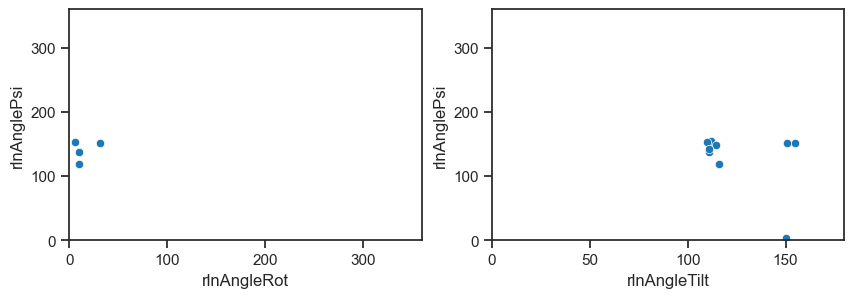

In [9]:
# Define paths and execute

# star path (input)
star_path = 'star_files/relion4.star'

# glyph path (input)
glyph_path = "glyphs/NN_munc13_membrane_binary.mrc"

# csv_path (output for paraview)
csv_path = f'paraview_csv/{tomo_id}/relion4.csv'

# map tomo path (output)
map_path = f'maps/{tomo_id}/relion4.mrc'

# transformed glyphs directory (output)
glyph_out_prefix = f'transformed_glyphs/{tomo_id}/relion4_'


# calculate visualization parameters
vis = Visualization(
    tomo_id_mode=tomo_id_mode, tomo_id_func=tomo_id_func, 
    tomo_id_kwargs=tomo_id_kwargs, micrograph_star=tomo_id_star_column,
    image_star=particle_id_star_column)
parts = vis.make_map_params(
    star_path=star_path, tomo_id=tomo_id, map_pixel_nm=map_pixel_nm, map_bin=map_bin, 
    map_offset=map_offset, coord_bin=coord_bin, 
    table_name=table_name, csv_path=csv_path)

# plot star file angles
plot_relion_angles(particles=parts)

# map averages (glyphs) on a tomo
parts_2 = vis.map_glyphs(
    glyph=glyph_path, params=parts, map_shape=map_shape, map_path=map_path, 
    map_pixel_nm=map_pixel_nm, threshold=None, glyph_bin=glyph_bin, map_bin=map_bin,
    glyph_out_prefix=glyph_out_prefix)

parts_2.head()

### Map particles from a Relion 3 star file

Uses Munc13 class average

In [10]:
# Parameters

# star particle data table name 
table_name = 'data'

# star column from which tomo id is determined
tomo_id_star_column = 'rlnMicrographName'

# star column from which particle id is determined 
particle_id_star_column = 'rlnImageName'

# specify tomo id and define how it is extracted from tomo_id_star_column 
# Generic method: tomo ids are the column values
#tomo_id = 'tomo_1-2-003'
#tomo_id_mode = None
#tomo_id_func = None
#tomo_id_kwargs = {}
# Alternative 1: tomo id is tomo base file name without extension
tomo_id = 'syn_m13_ctrl_327_bin2'
tomo_id_mode = None
tomo_id_func = (lambda x: os.path.splitext(os.path.basename(x))[0])
tomo_id_kwargs = {}
# Alternative 2: Used for the munc13-snap25 presynaptic project
#tomo_id = 'm13_ctrl_327'
#tomo_id_mode = 'munc13'
#tomo_id_func = None
#tomo_id_kwargs = {}

# map pixel size [nm]
map_pixel_nm = 1.76

# map shape
map_shape = (253, 126, 109)

# position (offset) of the map with respect to the star file coordinates
# in map_bin
map_offset = [473, 346, 139]

# star file coordinate, glyph and map bin factors, respectively 
# (with respect to the unbinned tomogram, or up to a common factor)
coord_bin = 2
glyph_bin = 2
map_bin = 4

Wrote paraview input csv file at paraview_csv/syn_m13_ctrl_327_bin2/relion3.csv
Wrote transformed glyph (particle id 313) at maps/syn_m13_ctrl_327_bin2/nn_munc13.mrc
Wrote transformed glyph (particle id 549) at maps/syn_m13_ctrl_327_bin2/nn_munc13.mrc
Wrote transformed glyph (particle id 646) at maps/syn_m13_ctrl_327_bin2/nn_munc13.mrc
Wrote transformed glyph (particle id 657) at maps/syn_m13_ctrl_327_bin2/nn_munc13.mrc
Wrote transformed glyph (particle id 832) at maps/syn_m13_ctrl_327_bin2/nn_munc13.mrc
Wrote transformed glyph (particle id 1105) at maps/syn_m13_ctrl_327_bin2/nn_munc13.mrc
Wrote transformed glyph (particle id 1244) at maps/syn_m13_ctrl_327_bin2/nn_munc13.mrc
Wrote transformed glyph (particle id 1938) at maps/syn_m13_ctrl_327_bin2/nn_munc13.mrc
Wrote transformed glyph (particle id 1941) at maps/syn_m13_ctrl_327_bin2/nn_munc13.mrc
Wrote mapped glyphs tomo at maps/syn_m13_ctrl_327_bin2/nn_munc13.mrc


,tomo_id,particle_id,rlnCoordinateX,rlnCoordinateY,rlnCoordinateZ,rlnAngleTilt,rlnAngleTiltPrior,rlnAnglePsi,rlnAnglePsiPrior,rlnAngleRot,...,v_z,box_center_x,box_center_y,box_center_z,box_min_x,box_min_y,box_min_z,box_max_x,box_max_y,box_max_z
82,syn_m13_ctrl_327_bin2,313,1194.0,835.0,448.0,86.730516,89.528,61.615780,63.768,-59.003220,...,0.057032,120,74,84,104,58,68,136,90,100
83,syn_m13_ctrl_327_bin2,549,1286.0,869.0,451.0,85.225292,85.550,69.580873,66.727,-79.041330,...,0.083238,170,90,87,154,74,71,186,106,103
84,syn_m13_ctrl_327_bin2,646,1133.0,803.0,346.0,87.291595,90.000,60.722298,62.871,138.572579,...,0.047253,88,62,34,72,46,18,104,78,50
85,syn_m13_ctrl_327_bin2,657,1165.0,821.0,465.0,88.515483,85.976,73.331489,70.436,-74.472670,...,0.025907,110,72,94,94,56,78,126,88,110
86,syn_m13_ctrl_327_bin2,832,1139.0,807.0,360.0,92.694767,90.000,64.949693,62.871,73.887287,...,-0.047015,98,62,42,82,46,26,114,78,58


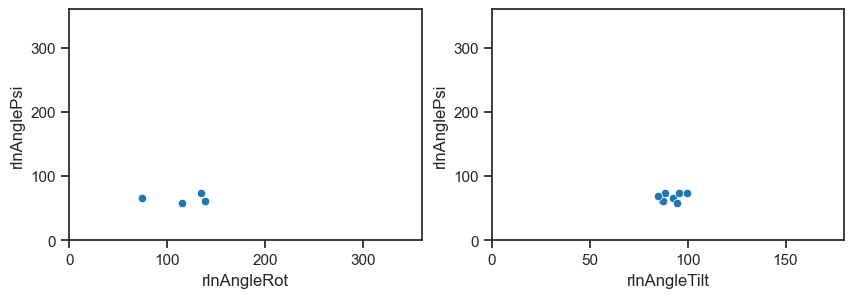

In [11]:
# munc13 nn class

# star path (input)
star_path = 'star_files/relion3.star'

# glyph path (input)
glyph_path = "glyphs/NN_munc13_membrane_binary.mrc"

# csv_path (output for paraview)
csv_path = f'paraview_csv/{tomo_id}/relion3.csv'

# map tomo path (output)
map_path = f'maps/{tomo_id}/nn_munc13.mrc'

# transformed glyphs directory (output)
glyph_out_prefix = f'transformed_glyphs/{tomo_id}/relion3_'


# calculate visualization parameters
vis = Visualization(
    tomo_id_mode=tomo_id_mode, tomo_id_func=tomo_id_func, 
    tomo_id_kwargs=tomo_id_kwargs, micrograph_star=tomo_id_star_column,
    image_star=particle_id_star_column)
parts = vis.make_map_params(
    star_path=star_path, tomo_id=tomo_id, map_pixel_nm=map_pixel_nm, map_bin=map_bin, 
    map_offset=map_offset, coord_bin=coord_bin, 
    table_name=table_name, csv_path=csv_path)

# plot star file angles
plot_relion_angles(particles=parts)

# map averages (glyphs) on a tomo
parts_2 = vis.map_glyphs(
    glyph=glyph_path, params=parts, map_shape=map_shape, map_path=map_path, 
    map_pixel_nm=map_pixel_nm, threshold=None, glyph_bin=glyph_bin, map_bin=map_bin,
    glyph_out_prefix=glyph_out_prefix)

parts_2.head()

### Generate and map a simple glyph

Can be used instead of averages

In [18]:
# make a simple glyph

# output path to simple glyph
simple_path = 'glyphs/simple.mrc'

# Arrow-like, not completely axially symmetric glyph, somposed of:
#  - main line along z axis
#  - widening in the middle of the glyph
#  - extension along positive y axis at the top of the main line
data = np.zeros((64, 64, 64), dtype='float32')
data[30:34, 30:34, 10:54] = 1
data[24:40, 24:40, 32] = 2
data[30:34, 30:44, 53:55] = 3
image = pyto.core.Image(data=data)
os.makedirs(os.path.dirname(simple_path), exist_ok=True)
image.write(file=simple_path, pixel=map_pixel_nm)

<_io.BufferedWriter name='glyphs/simple.mrc'>

In [19]:
# Parameters

# star particle data table name 
table_name = 'data'

# star column from which tomo id is determined
tomo_id_star_column = 'rlnMicrographName'

# star column from which particle id is determined 
particle_id_star_column = 'rlnImageName'

# specify tomo id and define how it is extracted from tomo_id_star_column 
# Generic method: tomo ids are the column values
#tomo_id = 'tomo_1-2-003'
#tomo_id_mode = None
#tomo_id_func = None
#tomo_id_kwargs = {}
# Alternative 1: tomo id is tomo base file name without extension
tomo_id = 'syn_m13_ctrl_327_bin2'
tomo_id_mode = None
tomo_id_func = (lambda x: os.path.splitext(os.path.basename(x))[0])
tomo_id_kwargs = {}
# Alternative 2: Used for the munc13-snap25 presynaptic project
#tomo_id = 'm13_ctrl_327'
#tomo_id_mode = 'munc13'
#tomo_id_func = None
#tomo_id_kwargs = {}

# map pixel size [nm]
map_pixel_nm = 1.76

# map shape
map_shape = (253, 126, 109)

# position (offset) of the map with respect to the star file coordinates
# in map_bin
map_offset = [473, 346, 139]

# star file coordinate, glyph and map bin factors, respectively 
# (with respect to the unbinned tomogram, or up to a common factor)
coord_bin = 2
glyph_bin = 2
map_bin = 4

Wrote paraview input csv file at paraview_csv/syn_m13_ctrl_327_bin2/simple_relion3.csv
Wrote transformed glyph (particle id 313) at maps/general/simple.mrc
Wrote transformed glyph (particle id 549) at maps/general/simple.mrc
Wrote transformed glyph (particle id 646) at maps/general/simple.mrc
Wrote transformed glyph (particle id 657) at maps/general/simple.mrc
Wrote transformed glyph (particle id 832) at maps/general/simple.mrc
Wrote transformed glyph (particle id 1105) at maps/general/simple.mrc
Wrote transformed glyph (particle id 1244) at maps/general/simple.mrc
Wrote transformed glyph (particle id 1938) at maps/general/simple.mrc
Wrote transformed glyph (particle id 1941) at maps/general/simple.mrc
Wrote mapped glyphs tomo at maps/general/simple.mrc


,tomo_id,particle_id,rlnCoordinateX,rlnCoordinateY,rlnCoordinateZ,rlnAngleTilt,rlnAngleTiltPrior,rlnAnglePsi,rlnAnglePsiPrior,rlnAngleRot,...,v_z,box_center_x,box_center_y,box_center_z,box_min_x,box_min_y,box_min_z,box_max_x,box_max_y,box_max_z
82,syn_m13_ctrl_327_bin2,313,1194.0,835.0,448.0,86.730516,89.528,61.615780,63.768,-59.003220,...,0.057032,120,74,84,104,58,68,136,90,100
83,syn_m13_ctrl_327_bin2,549,1286.0,869.0,451.0,85.225292,85.550,69.580873,66.727,-79.041330,...,0.083238,170,90,87,154,74,71,186,106,103
84,syn_m13_ctrl_327_bin2,646,1133.0,803.0,346.0,87.291595,90.000,60.722298,62.871,138.572579,...,0.047253,88,62,34,72,46,18,104,78,50
85,syn_m13_ctrl_327_bin2,657,1165.0,821.0,465.0,88.515483,85.976,73.331489,70.436,-74.472670,...,0.025907,110,72,94,94,56,78,126,88,110
86,syn_m13_ctrl_327_bin2,832,1139.0,807.0,360.0,92.694767,90.000,64.949693,62.871,73.887287,...,-0.047015,98,62,42,82,46,26,114,78,58


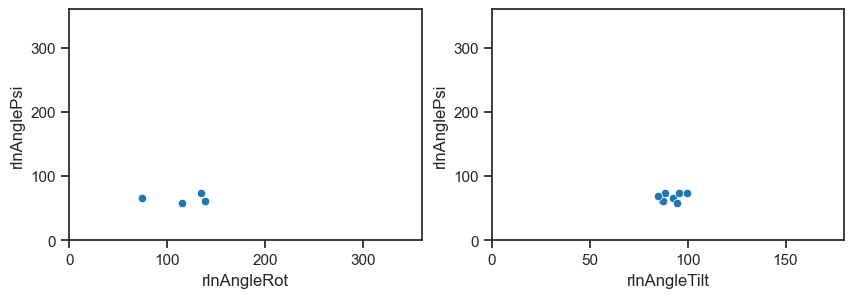

In [20]:
# simple glyph, use munc13 class data

# star path (input)
star_path = 'star_files/relion3.star'

# glyph path (input)
glyph_path = simple_path

# csv_path (output for paraview)
csv_path = f'paraview_csv/{tomo_id}/simple_relion3.csv'

# map tomo path (output)
map_path = 'maps/general/simple.mrc'

# transformed glyphs directory (output)
glyph_out_prefix = f'transformed_glyphs/{tomo_id}/simple_'


# calculate visualization parameters
vis = Visualization(
    tomo_id_mode=tomo_id_mode, tomo_id_func=tomo_id_func, 
    tomo_id_kwargs=tomo_id_kwargs, micrograph_star=tomo_id_star_column,
    image_star=particle_id_star_column)
parts = vis.make_map_params(
    star_path=star_path, tomo_id=tomo_id, map_pixel_nm=map_pixel_nm, map_bin=map_bin, 
    map_offset=map_offset, coord_bin=coord_bin, 
    table_name=table_name, csv_path=csv_path)

# plot star file angles
plot_relion_angles(particles=parts)

# map averages (glyphs) on a tomo
parts_2 = vis.map_glyphs(
    glyph=glyph_path, params=parts, map_shape=map_shape, map_path=map_path, 
    map_pixel_nm=map_pixel_nm, threshold=None, glyph_bin=glyph_bin, map_bin=map_bin,
    glyph_out_prefix=glyph_out_prefix)

parts_2.head()